In [1]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
# from models import GCNClassifier
from utils import Mydataset, create_param_list, create_train_data_hold_out

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [2]:
nconf = 31
ndata = 500
L = 64
T_cr = 2.269 # critical temp for 2d ising
t_start = 2.1

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Ising")
print(prm_list)
print(f"データ数:{nconf*ndata}")

[[2.1, '../dataset/2d_Ising/L64/L64T0_'], [2.11, '../dataset/2d_Ising/L64/L64T1_'], [2.12, '../dataset/2d_Ising/L64/L64T2_'], [2.13, '../dataset/2d_Ising/L64/L64T3_'], [2.14, '../dataset/2d_Ising/L64/L64T4_'], [2.15, '../dataset/2d_Ising/L64/L64T5_'], [2.16, '../dataset/2d_Ising/L64/L64T6_'], [2.17, '../dataset/2d_Ising/L64/L64T7_'], [2.18, '../dataset/2d_Ising/L64/L64T8_'], [2.19, '../dataset/2d_Ising/L64/L64T9_'], [2.2, '../dataset/2d_Ising/L64/L64T10_'], [2.21, '../dataset/2d_Ising/L64/L64T11_'], [2.22, '../dataset/2d_Ising/L64/L64T12_'], [2.23, '../dataset/2d_Ising/L64/L64T13_'], [2.24, '../dataset/2d_Ising/L64/L64T14_'], [2.25, '../dataset/2d_Ising/L64/L64T15_'], [2.26, '../dataset/2d_Ising/L64/L64T16_'], [2.27, '../dataset/2d_Ising/L64/L64T17_'], [2.28, '../dataset/2d_Ising/L64/L64T18_'], [2.29, '../dataset/2d_Ising/L64/L64T19_'], [2.3, '../dataset/2d_Ising/L64/L64T20_'], [2.31, '../dataset/2d_Ising/L64/L64T21_'], [2.32, '../dataset/2d_Ising/L64/L64T22_'], [2.33, '../dataset/2d_I

In [4]:
# hold out
train_dataset, valid_dataset, test_dataset = create_train_data_hold_out(prm_list, ndata, T_cr, exclude_T=(2.23, 2.31), total_label=2)
print("train_dataset.shape = ", len(train_dataset))
print("valid_dataset.shape = ", len(valid_dataset))
print("test_dataset.shape = ", len(test_dataset))

train_graphset = Mydataset(train_dataset)
valid_graphset = Mydataset(valid_dataset)
test_graphset = Mydataset(test_dataset)

BATCH_SIZE = 1024
train_loader = DataLoader(train_graphset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_graphset, batch_size=BATCH_SIZE, shuffle=False)

train_dataset.shape =  8800
valid_dataset.shape =  2200
test_dataset.shape =  3100


In [5]:
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNClassifier(nn.Module):
    def __init__(self, target_size):
        super().__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, target_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def edge_reconnect(self, x, k):
        distance_matrix = torch.cdist(x, x, p=2)
        _, indices = torch.topk(distance_matrix, k)
        edge_from = torch.arange(x.shape[0]).view(-1, 1).repeat(1, k)
        edge_to = indices
        edge_index = torch.stack([edge_from.view(-1), edge_to.view(-1)], dim=0)
        return edge_index

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch

        x = self.relu(self.conv1(x, edge_index))
        # edge_index = self.edge_reconnect(x, k = 5)
        x = self.relu(self.conv2(x, edge_index))
        # edge_index = self.edge_reconnect(x, k = 5)
        x = global_mean_pool(x, batch)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
LEARNING_RATE = 0.0001
target_size = 2
grad_clip = 0.1
norm_type = 2
epochs = 10
model = GCNClassifier(target_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_list = []
accuracy_list = []
for epoch in range(epochs):
    # training
    model.train()
    train_loss = 0
    for data, _, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item()
        del loss
        nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
        optimizer.step()
    # train_loss_list.append(train_loss)

    # inference
    model.eval()
    valid_loss = 0
    correct = 0
    answer, prediction = [], []
    with torch.no_grad():
        for data, _, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            prediction += list(pred.cpu().numpy())
            answer += list(target.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    loss_list.append(valid_loss)
    accuracy_list.append(accuracy)
    if epoch % 2 == 0:
        print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
        print("Classification Report:\n", classification_report(answer, prediction, digits=4))
print("done.")

mps is available.


ValueError: Encountered invalid 'dim_size' (got '3141308' but expected >= '1094494075433425601')

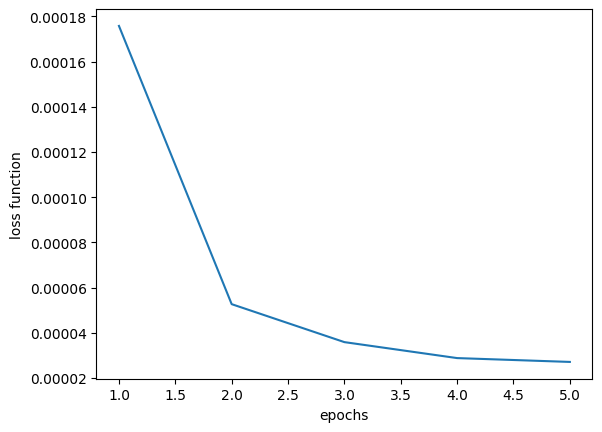

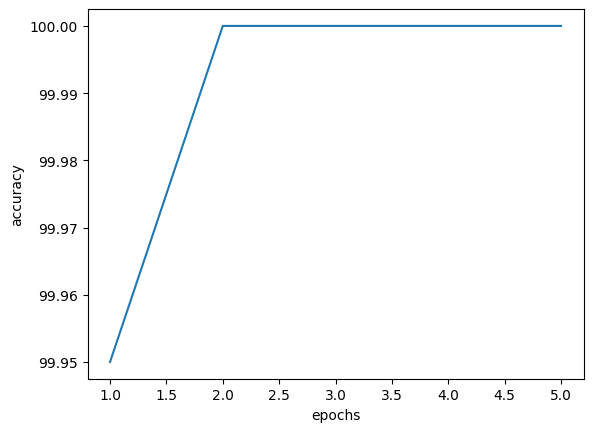

In [ ]:
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.plot(np.arange(1, epochs+1), loss_list)
plt.show()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(np.arange(1, epochs+1), accuracy_list)
plt.show()

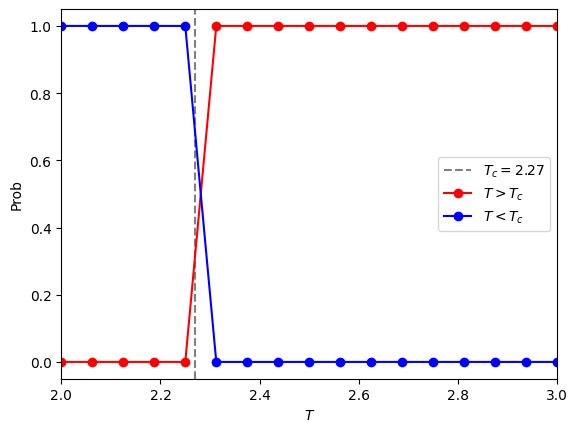

In [ ]:
test_loader = DataLoader(test_graphset, batch_size=BATCH_SIZE, shuffle=False)

xs, y1s, y2s, temps = [], [], [], []
prediction = []
sum_pred = 0
count = 0

model.eval()
for data, temp, target in test_loader:
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=False)
    prediction += list(pred.cpu().numpy())
    temps += list(temp.cpu().numpy())
# print(len(prediction), len(temps))

for i in range(len(test_dataset)):
    if i == 0:
        sum_pred += prediction[i]
        count += 1
        xs.append(temps[i])
    else:
        if temps[i] != temps[i-1]:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)

            sum_pred = 0
            count = 0
            sum_pred += prediction[i]
            count += 1
            xs.append(temps[i])
        elif i == len(test_dataset)-1:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)
        else:
            sum_pred += prediction[i]
            count += 1
# print(len(xs), len(y1s), len(y2s))

plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={}$".format(T_cr))
plt.xlim(t_start,t_end)
plt.plot(xs, y1s, label=r"$ferro$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$para$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()